In [1]:
%config InlineBackend.figure_format = "svg"

from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import accuracy_score
from torch.autograd import Variable
import matplotlib.pyplot as plt
import torch.nn.functional as F
from tqdm.notebook import tqdm
from math import ceil, log
import pennylane as qml
import pandas as pd
import numpy as np
import torch

# Quantum-Classical Hybrid Neural Network Classifier

In this notebook, we will take a look at a quantum-classical hybric neural network, using `Pennylane` together with `PyTorch`, in order to classify `MNIST` images.

We have at our disposal the `MNIST` dataset:
$$\mathcal{D} = \{(X^{(1)}, Y^{(1)}), (X^{(2)}, Y^{(2)}), \dots, (X^{(M)}, Y^{(M)})\}$$
$$X^{(i)} = \{\mathbf{x}^{(i,1)}, \mathbf{x}^{(i,2)}, \dots, \mathbf{x}^{(i,B)}\}, \; \mathbf{x}^{(i,j)} \in \mathbb{R}^{28\times28}$$
$$Y^{(i)} = \{y^{(i,1)}, y^{(i,2)}, \dots, y^{(i,B)}\}, \; y^{(i,j)} \in \{0,1,\dots,9\}$$

Representing the $M$ **batches** each containing $B$ images of $28\times28$ pixels and labels belonging to one of $10$ classes.

We will solve this classification problem using a model with three layers:
- A quantum variational circuit that outputs the expectation value of each qubit $f_k(\mathbf{x}, \theta) = \langle 0| U^{\dagger}(\theta) S^{\dagger}(\mathbf{x}) Z S(\mathbf{x}) U(\theta) |0 \rangle$:
    - $S(\mathbf{x})$ represents the classical to quantum encoding circuit
    - $U(\theta)$ represents the parameterized *ansatz* of our circuit
    - $Z$ is the Pauli Z gate
- Two classical *fully connected* layers (layers composed of multiple *neurons*)

For each neuron in first classical fully connected layer, its output $s_k$ will be given by a non-linearity on the output of the corresponding qubit of the QVC (the number of qubits in the QVC must match the number of neurons in the fully connected layer):

$$ s^{(1)}_k = \mathtt{relu} \left( f_k(\mathbf{x}, \theta) = \langle 0| U^{\dagger}(\theta) S^{\dagger}(\mathbf{x}) Z S(\mathbf{x}) U(\theta) |0 \rangle \right) $$

Where $\mathtt{relu}(x)$ is $0$ if $x < 0$ and $x$ if $x \ge 0$.

The output of the second classical layer (and of the whole model) given the output of the neurons of the first layer can be expressed as:

$$ \mathbf{f} = W^{(1)} \mathbf{s}^{(1)} + \mathbf{b}^{(2)} $$

Where $W^{(1)}$ is the adjacency matrix of the weighted edges connecting neurons from layer $1$ to layer $2$ and $\mathbf{b}^{(i)}$ are the *biases* of the neurons in the second layer.

By comparing the output of the circuit, we can compare it with the corresponding label of the input by using the *cross entropy* loss function, and consequently optimize the model parameters $\theta^{\star}$ (both the ansatz's and the fully connected layers' parameters) by minimizing this loss:

$$ \min_{\theta^{\star}} \mathcal{L}(\mathbf{f}(\theta^{\star}), y) = - \log \left( \frac{\exp \left( \mathbf{f}[y] \right)}{\sum_{j} \exp \left( \mathbf{f}[j] \right)} \right) $$

## The quantum variational circuit architecture

### Data encoding

The first part of our QVC is responsible for encoding our classical data into qubits in our circuit.
A very popular and robust choice is **dense angle encoding**. Suppose we have a feature vector $\mathbf{x} = [x_1, x_2, \dots, x_N]^T$. To encode it into a quantum state $| \psi \rangle$, we apply the following equation:

$$ |\psi\rangle = \bigotimes_{k=1}^{\left \lceil N/2 \right \rceil} \left( \cos(\pi x_{2k-1}) |0\rangle + e^{2 \pi i x_{2k}}\sin(\pi x_{2k-1}) |1\rangle \right) $$

By using the `qml.PhaseShift` and `qml.RY` gates:

$$ R_{\phi}(\phi) = \left[ \begin{matrix} 1 & 0 \\ 0 & e^{i\phi} \end{matrix} \right], \; R_y(\lambda) = \left[ \begin{matrix} \cos(\lambda / 2) & \sin(\lambda / 2) \\ -\sin(\lambda/2) & cos(\lambda/2) \end{matrix} \right] $$

We can simplify this expression to:

$$ |\psi\rangle = \bigotimes_{k=1}^{\left \lceil N/2 \right \rceil} R_{\phi_k}(\phi_k)R_y(\lambda_k) |0\rangle, \; \phi_k = 2 \pi x_{2k},\; \lambda_k = 2 \pi x_{2k-1} $$

And can be expressed in circuit notation as:

## MNIST image dataset

This `MNIST` dataset can be downloaded from `Kaggle`: https://www.kaggle.com/oddrationale/mnist-in-csv

In [2]:
# Number of classes to distinguish
nr_classes = 4

# Load data
path = "/home/gilbertocunha/Documentos/GitHub/QuantumVariationalCircuits/data/"
X_train = pd.read_csv(path + "mnist_train.csv")
X_test = pd.read_csv(path + "mnist_test.csv")

# Remove extra classes according to the above hyperparameter
X_train = X_train[X_train["label"] < nr_classes]
X_test = X_test[X_test["label"] < nr_classes]
X_train

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59985,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59987,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59991,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59994,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
# Get labels from data (only load 10% of the data)
y_train = X_train["label"].to_numpy()[:len(X_train)//10]
y_test = X_test["label"].to_numpy()[:len(X_test)//10]
print(y_train.shape, y_test.shape)

# Get features from data
X_train = X_train.drop("label", axis=1).to_numpy()[:len(X_train)//10]
X_test = X_test.drop("label", axis=1).to_numpy()[:len(X_test)//10]
print(X_train.shape, X_test.shape)

(2475,) (415,)
(2475, 784) (415, 784)


### A quick look at the data

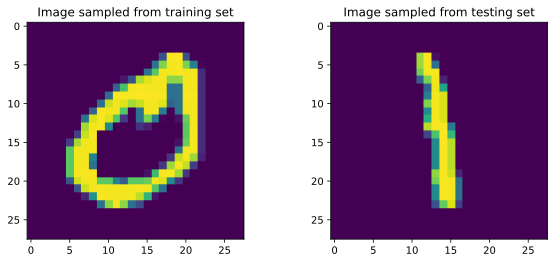

In [4]:
train_idx, val_idx = 10, 24
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].set_title("Image sampled from training set")
axs[0].imshow(X_train[train_idx].reshape(28,28))
axs[1].set_title("Image sampled from testing set")
axs[1].imshow(X_test[train_idx].reshape(28,28))
plt.show()

**Important Note**: Our data is too big, each feature vector has 784 pixels, which would take up way too many qubits to be encoded in a quantum circuit. To heavily reduce this number, we will utilize a dimensionality reduction technique named *truncated Single Valued Decomposition*, to reduce our feature vector to a feasible size, while (trying to) maintaining the classes separated. The size of our feature vector after a dimensionality reduction should be a power of two, due to our selected quantum circuit encoding.

Fortunately, `sklearn` already has a very high level and easily applicable implementation of such a technique.

In [5]:
# Concatenate train and test data
X_total = np.concatenate((X_train, X_test))

# Apply TSVD
tsvd = TruncatedSVD(n_components=8)
X_total = tsvd.fit_transform(X_total)

# Split train and test data again
X_train = X_total[:len(X_train)]
X_test = X_total[len(X_train):]
print(X_train.shape, X_test.shape)

(2475, 8) (415, 8)


Finally, our data needs to be normalized in order to be passed through a quantum circuit. Therefore, we will normalize it

In [6]:
def normalize (matrix):
    """
    Normalizes vector squared amplitudes to one
    for every vector in the input matrix
    """
    norm = np.sqrt(np.sum(matrix ** 2, -1))
    r = []
    for i in range(len(matrix)):
        r.append(matrix[i,:]/norm[i])
    r = np.array(r)
    return r

In [7]:
# Normalize our data
X_train = normalize(X_train)
X_test = normalize(X_test)

Let's check if data is still easily separable after dimensionality reduction. (We can change the dimensions we plot against each other to see if the classes are well separated in any possible dimension combination)

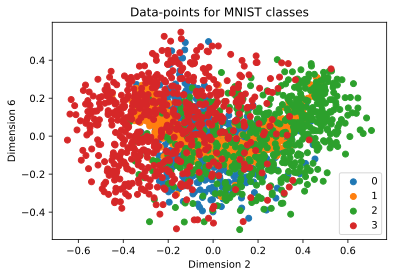

In [8]:
# Plotting training data
dim1, dim2 = 2, 6
plt.title("Data-points for MNIST classes")
for i in range(nr_classes):
    plt.scatter(X_train[y_train == i][:,dim1], X_train[y_train == i][:,dim2], label=f"{i}")
plt.xlabel(f"Dimension {dim1}")
plt.ylabel(f"Dimension {dim2}")
plt.legend()
plt.show()

Unfortunately, we can see that the dimensionality reduction does not work too well to separate this dataset for a high number of classes. We will still try to make the model learn from this compressed dataset, because otherwise the number of qubits to be used would be just way too large.

## Dataset Class

To make our lives easier to iterate a dataset in our training loop, we will go ahead and implement a dataset class with some useful methods for later use.

In [9]:
class Dataset:
    def __init__(self, features, labels, batch_size, encoding="angle"):
        """
        This function initializes a Dataset object and its atributes
        """
        # Randomly shuffle indices of the data
        idx = np.random.permutation(len(features))
        
        # Split data into batches
        self.features = Variable(torch.tensor(self.split(features[idx], batch_size)), requires_grad=False)
        self.labels = Variable(torch.tensor(self.split(labels[idx], batch_size)), requires_grad=False)
        
        # Save other class atributes
        self.batch_size = batch_size
        self.encoding = encoding
        self.counter = 0
        
        assert len(self.features) == len(self.labels), "features and labels have different sizes"
        
    def split(self, array, batch_size):
        """
        A auxiliary function to split an entire dataset into batches
        of size "batch size".
        """
        r = []
        num_splits = len(array)//batch_size
        for i in range(num_splits):
            start = i*batch_size
            size = batch_size
            r.append(array[start:start+size])
        r = np.stack(r, axis=0)
        return r
    
    def feature_size(self):
        """
        Outputs the size of each feature in our dataset
        """
        return len(self.features[0][0])
        
    def num_qubits(self):
        """
        Returns the number of qubits needed to encode each feature
        into a quantum circuit
        """
        if self.encoding == "angle":
            r = ceil(self.feature_size() / 2)
        else:
            r = ceil(log(self.feature_size(), 2))
            
        return r
        
    def sample_batch(self):
        """
        A method that samples a batch from the dataset
        """
        features = self.features[self.counter]
        labels = self.labels[self.counter]
        self.counter = (self.counter + 1) % len(self.features)
        return features, labels
    
    def __len__(self):
        """
        A method that returns the size of the dataset.
        Can be called as "len(dataset)" instead of
        "dataset.__len__()"
        """
        return len(self.features)

## Train, Val, Test split

Now we will split the original dataset into three sets:
- **Training set**: will be used to update the model's parameters during the training phase
- **Validation set**: will be used to check the model's generalization on new data during the training phase
- **Test set**: a dataset to evaluate our final model and it's generalization on entirely new data

In [10]:
# Splitting data into train, test and validation
val_split, random_state = 0.2, 42
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_split, random_state=random_state)

# Creating the datasets for train, test and validation
batch_size, encoding = 32, "angle"
trainset = Dataset(X_train, y_train, batch_size, encoding)
valset = Dataset(X_val, y_val, batch_size, encoding)
testset = Dataset(X_test, y_test, batch_size, encoding)

## Quantum Variational Circuit hyperparameters

In [11]:
# number of qubits in the circuit
nr_qubits = trainset.num_qubits()

# number of layers in the circuit
nr_layers = 2

# define quantum device
dev = qml.device("default.qubit", wires=nr_qubits)

## Quantum Variational Circuit Implementation

In [12]:
def combinations(values):
    """
    Calculates every possible pair combination of values
    """
    r = []
    for i in range(len(values)):
        for j in range(i+1,len(values)):
            r.append((i,j))
    return r

# Dense angle encoding
def dense_angle_encoding(inputs):
    nr_qubits = ceil(len(inputs) / 2)
    for k in range(nr_qubits):
        x1 = 2 * np.pi * inputs[2*k]
        x2 = 2 * np.pi * inputs[2*k+1]
        qml.RY(x1, wires=k)
        qml.PhaseShift(x2, wires=k)

# a layer of the circuit ansatz
def layer(params, j):
    for i in range(params.shape[1]):
        qml.RX(params[j, i, 0], wires=i)
        qml.RY(params[j, i, 1], wires=i)
        qml.RZ(params[j, i, 2], wires=i)

    # Add CNOT for every qubit combination
    combs = combinations(range(params.shape[1]))
    for i, k in combs:
        if j % 2 == 1:
            i, k = k, i
        qml.CNOT(wires=[i, k])

@qml.qnode(dev)
def qnode(inputs, params):
    # Encoding
    if encoding == "angle": dense_angle_encoding(inputs)
    else: qml.QubitStateVector(inputs, wires=range(params.shape[1]))
    
    # repeatedly apply each layer in the circuit
    for j in range(params.shape[0]):
        layer(params, j)

    # returns the expectation of the input matrix A on the first qubit
    measurements = [qml.expval(qml.PauliZ(i)) for i in range(params.shape[1])]
    return measurements

# cost function
def loss_fn(predictions, labels):
    """
    A simple square loss function to evaluate predictions
    """
    loss = 0.0
    for p, l in zip(predictions, labels):
        loss += (l - p) ** 2
    return loss

## Pytorch Hybrid Classical-Quantum Integration

Finally, `Pennylane` allows us to transform a `qnode` object into a `PyTorch` layer using the function `qml.qnn.TorchLayer`, which we can use to integrate it into a regular classical `PyTorch` model.

In [13]:
class Model(torch.nn.Module):
    def __init__(self, qnode, nr_layers, nr_qubits, nr_classes):
        super(Model, self).__init__()
        self.qvc = qml.qnn.TorchLayer(qnode, {"params": (nr_layers, nr_qubits, 3)})
        self.linear1 = torch.nn.Linear(nr_qubits, 10)
        self.linear2 = torch.nn.Linear(10, nr_classes)
        
    def forward(self, x):
        x = self.qvc(x)
        x = F.relu(self.linear1(x))
        x = self.linear2(x)
        return x
    
# Create pytorch model, optimizer and loss function
model = Model(qnode, nr_layers, nr_qubits, nr_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=0.04)
loss_fn = torch.nn.CrossEntropyLoss()

# Training loop for the hybrid model

Now all that is left to do is to train the model!
We can additionally also save the model's *best weights* (generally evaluated using metrics on the validation set), so that we can, at the end of the training phase, load our *best* model to predict on our *test set*.

In [14]:
# Number of epochs to train on
epochs = 10

# Best accuracy and loss
best_tr_acc, best_val_acc = 0, 0
best_tr_loss, best_val_loss = float("inf"), float("inf")

# Performing the training loop
epoch_tqdm = tqdm(range(epochs), total=epochs, desc="Fitting")
for epoch in epoch_tqdm:
    # Iterate training data
    tr_accs, tr_losses = [], []
    tr_tqdm = tqdm(range(len(trainset)), total=len(trainset), desc="Training")
    for _ in tr_tqdm:
        # Sample batch of data and get predictions
        X, y = trainset.sample_batch()
        y_hat = model(X.float())

        # Get loss and update parameters
        optimizer.zero_grad()
        loss = loss_fn(y_hat, y)
        loss.backward()
        optimizer.step()
        
        # Add training info to tqdm progress bar
        y_hat = torch.argmax(y_hat.detach(), dim=-1)
        tr_acc = accuracy_score(y, y_hat)
        info = {"loss": loss.item(), "acc": tr_acc}
        tr_tqdm.set_postfix(info)
        tr_accs.append(tr_acc)
        tr_losses.append(loss.item())
        
    # Calculate training epoch accuracy and loss
    tr_acc = sum(tr_accs) / len(tr_accs)
    tr_loss = sum(tr_losses) / len(tr_losses)
    
    # Get best loss and accuracy
    if tr_acc > best_tr_acc: best_tr_acc = tr_acc
    if tr_loss < best_tr_loss: best_tr_loss = tr_loss
        
    # Iterate validation data
    val_accs, val_losses = [], []
    val_tqdm = tqdm(range(len(valset)), total=len(valset), desc="Validating")
    with torch.no_grad():
        for _ in val_tqdm:
            # Sample batch of data and get predictions
            X, y = valset.sample_batch()
            y_hat = model(X.float())
            loss = loss_fn(y_hat, y)

            # Add validation info to tqdm progress bar
            y_hat = torch.argmax(y_hat.detach(), dim=-1)
            val_acc = accuracy_score(y, y_hat)
            info = {"loss": loss.item(), "acc": val_acc}
            val_tqdm.set_postfix(info)
            val_accs.append(val_acc)
            val_losses.append(loss.item())
            
    # Calculate training epoch accuracy and loss
    val_acc = sum(val_accs) / len(val_accs)
    val_loss = sum(val_losses) / len(val_losses)
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "models/best_model_dict.pt")
    if val_loss < best_val_loss: best_val_loss = val_loss
    
    # Update info to tqdm bar
    info = {
        "b_tr_acc": best_tr_acc, 
        "b_tr_loss": best_tr_loss, 
        "b_val_acc": best_val_acc, 
        "b_val_loss": best_val_loss
    }
    epoch_tqdm.set_postfix(info)

Fitting:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Validating:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Validating:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Validating:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Validating:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Validating:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Validating:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Validating:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Validating:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Validating:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Validating:   0%|          | 0/15 [00:00<?, ?it/s]

## Testing the best model on unseen data

After the training loop has completed, we can load the best weights of the model:

In [15]:
test_model = Model(qnode, nr_layers, nr_qubits, nr_classes)
test_model.load_state_dict(torch.load("models/best_model_dict.pt"))
test_model.eval()

Model(
  (qvc): <Quantum Torch Layer: func=qnode>
  (linear1): Linear(in_features=4, out_features=10, bias=True)
  (linear2): Linear(in_features=10, out_features=4, bias=True)
)

And predict on our test set to see how well the algorithm generalizes.

In [16]:
test_accs, test_losses = [], []
test_tqdm = tqdm(range(len(testset)), total=len(testset), desc="Testing")
with torch.no_grad():
    for _ in test_tqdm:
        # Sample batch of data and get predictions
        X, y = testset.sample_batch()
        y_hat = test_model(X.float())
        loss = loss_fn(y_hat, y)

        # Add test info to tqdm progress bar
        y_hat = torch.argmax(y_hat.detach(), dim=-1)
        test_acc = accuracy_score(y, y_hat)
        info = {"loss": loss.item(), "acc": test_acc}
        test_tqdm.set_postfix(info)
        test_accs.append(test_acc)
        test_losses.append(loss.item())

# Get final test loss and accuracy
test_loss = sum(test_losses) / len(test_losses)
test_acc = sum(test_accs) / len(test_accs)

# Display the final results
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_acc}")

Testing:   0%|          | 0/12 [00:00<?, ?it/s]

Test Loss: 0.5410553812980652
Test Accuracy: 0.7760416666666666
